In [1]:
#Snowflake
from sqlalchemy import create_engine, sql
from snowflake.sqlalchemy import URL

#Librairies
from os import environ
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
%matplotlib inline

/Users/alicegoulley/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (4.0.1), please install a version that adheres to: 'pyarrow<6.1.0,>=6.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
url = URL(
    account = environ.get('SNOWFLAKE_ACCOUNT'),
    user = environ.get('SNOWFLAKE_USER'),
    password = environ.get('SNOWFLAKE_PWD'),
    database = 'production',
    schema = 'common',
    warehouse = environ.get('SNOWFLAKE_WH'),
    role = environ.get('SNOWFLAKE_ROLE'),
)

In [3]:
qstr = '''
    
    select distinct
        rentals.id,
        car_id,
        precise_ends_at,
        checkin_mileage,
        checkout_mileage,
        lag(checkout_mileage) over (partition by car_id order by precise_ends_at) as previous_checkout_mileage,
        checkout_mileage - checkin_mileage as mileage_run

    from common.rentals 

    left join common.cars
        on rentals.car_id = cars.id 

    where rentals.state = 'ended'
    and is_open
    and cars.state = 'active'
    and checkin_type = 'open'
    and date(precise_ends_at) >= date_trunc(month,dateadd(month, -12, getdate()))



'''


In [4]:
engine_snowflake = create_engine(url)
connection = engine_snowflake.connect()
try:
    df = pd.read_sql(
        qstr, 
        engine_snowflake
        
    )
    # You can directly cast the date columns as dates by adding in 
    # pd.read_sql_query the arg parse_dates=['name_column_date1','name_column_date2']
finally:
    connection.close()
    engine_snowflake.dispose()

In [5]:
df.head()

,id,car_id,precise_ends_at,checkin_mileage,checkout_mileage,previous_checkout_mileage,mileage_run
0,6131009,853912,2021-08-15 21:30:00,11837.0,13314.0,11837.0,1477.0
1,6268885,853912,2021-09-26 17:30:00,NaN,15016.0,NaN,NaN
2,6348346,853912,2021-11-11 16:00:00,17415.0,18222.0,17415.0,807.0
3,6591767,853912,2022-03-19 18:00:00,26138.0,26237.0,26138.0,99.0
4,6487142,953519,2022-02-06 09:00:00,127755.0,127780.0,127755.0,25.0


<AxesSubplot:>

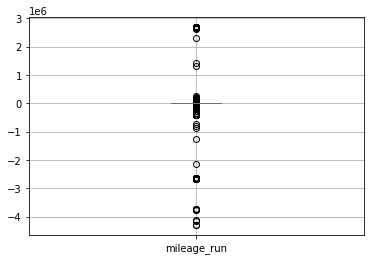

In [6]:
df.boxplot('mileage_run')

In [7]:
df = df[df['mileage_run']>0]

<AxesSubplot:>

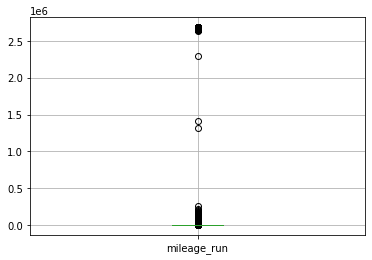

In [8]:
df.boxplot('mileage_run')

In [9]:
df['mileage_run'].describe()

count    3.676280e+05
mean     7.514910e+03
std      1.386187e+05
min      1.000000e+00
25%      6.400000e+01
50%      1.550000e+02
75%      3.560000e+02
max      2.684350e+06
Name: mileage_run, dtype: float64

In [19]:
Q1 = 6.400000e+01
Q3 = 3.560000e+02

In [20]:
IQR = Q3 - Q1

In [21]:
IQR

292.0

In [22]:
lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR

In [23]:
lower_range

-374.0

In [24]:
upper_range

794.0

In [25]:
df2 = df.loc[((df['mileage_run']<upper_range)\
       & (df['mileage_run']>lower_range))
       | (df['mileage_run'].isna())]

In [26]:
df2['mileage_run'].describe()

count    340078.000000
mean        200.200410
std         182.794096
min           1.000000
25%          59.000000
50%         138.000000
75%         291.000000
max         793.000000
Name: mileage_run, dtype: float64

<AxesSubplot:>

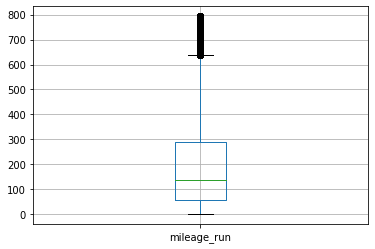

In [27]:
df2.boxplot('mileage_run')